In [2]:
!pip install shap==0.41.0
!pip install xgboost==1.7.2
!pip install transformers

# Model explainability
This notebook contains the selected ideas on the topic of model explainability. In many real-life scenarios, preparing a well-performing model is only the first step. A quote from a known [book on this topic ](https://link.springer.com/content/pdf/10.1007/978-3-030-28954-6.pdf?pdf=button)goes as follows:
```
Clearly, for sensitive tasks involving critical infrastructures and affecting human
well-being or health, it is crucial to limit the possibility of improper, non-robust, and
unsafe decisions and actions [4]. Before deploying an AI system, we see a strong need
to validate its behavior, and thus establish guarantees that it will continue to perform as
expected when deployed in a real-world environment.
```

In order to convince a domain expert that the model really works as it should, explainability is becoming of high relevance. Let's start with a generic tabular example. Consider


*   A "black-box" model, such as XGBoost
*   A data set representing adults

We will first explore the widely used SHAP library: https://github.com/slundberg/shap/tree/master/shap



In [3]:
import xgboost
import shap
import matplotlib.pyplot as plt

# train an XGBoost model
X, y = shap.datasets.adult()

/Users/azagar/miniconda3/envs/is/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/azagar/miniconda3/envs/is/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

In [4]:
print(X)

        Age  Workclass  Education-Num  Marital Status  Occupation  \
0      39.0          7           13.0               4           1   
1      50.0          6           13.0               2           4   
2      38.0          4            9.0               0           6   
3      53.0          4            7.0               2           6   
4      28.0          4           13.0               2          10   
...     ...        ...            ...             ...         ...   
32556  27.0          4           12.0               2          13   
32557  40.0          4            9.0               2           7   
32558  58.0          4            9.0               6           1   
32559  22.0          4            9.0               4           1   
32560  52.0          5            9.0               2           4   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0                 0     4    1        2174.0           0.0            40.0   
1              

The target variable corresponds to yearly earnings (>50k) 
-- from SHAP's source data["Target"] = data["Target"] == " >50K"

In [5]:
print(y)

[False False False ... False False  True]


Having obtained some intuition about the data set, we can proceed to the modeling phase. For demonstration purposes, we use the full data set.

Using SHAP framework, three main steps

*   train a model on the relevant space of data.
*   Compute Shapley values
*   Visualize






In [6]:
model = xgboost.XGBRegressor().fit(X, y)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


At this point, we have a model that learned to associate X->y. But what impacts these associations?

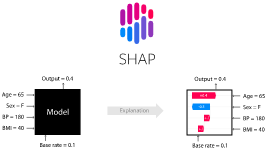

In [7]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Let's inspect the obtained objects.

In [ ]:
print(explainer)

In [ ]:
shap_values.values.shape

We obtain a vector for each _instance_.

In [ ]:
print(X.shape)
print(shap_values.values[123])

Common usecase are visualizations. Let's explore the most common ones.

In [ ]:
# Let's explain instance with index 123
shap.plots.waterfall(shap_values[123])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[123])

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
# Let's visualize the impact across a part of the instance space
shap.initjs()
shap.plots.force(shap_values[0:123])

# Interpretation of SHAP values


1.   Shap values tell us the impact of a particular feature(value) in the actual prediction
2.   NOT the importance of the feature in general



Alternative tool -> LIME: https://github.com/marcotcr/lime

# Non-tabular data can be explained too
We will next consider an example that uses a pre-trained transformer for the task of sentiment classification.

In [ ]:
!pip install transformers

In [ ]:
import transformers
import shap

# our input
sentence_considered = "This movie is one of the worst things that happened to me."

# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model) 

# compute the Shapley values
shap_values = explainer([sentence_considered])

# visualize the first prediction's explanation for the NEGATIVE output class
shap.plots.text(shap_values[0, :, "NEGATIVE"])


We can do the same with images. We'll reuse the code from the previous exercices to train an image classifier and then use SHAP to explain the predictions.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

num_classes = 10
input_shape = (28, 28, 1) 


(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), # Convolutions
        layers.MaxPooling2D(pool_size=(2, 2)), # Pooling
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
     
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

batch_size = 128 
epochs = 3 


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [ ]:

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[0:10])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[0:10])

Are there machine learning models that are built with interpretability in mind from the get-go? We will consider the recent _interpret_ library found here: https://github.com/interpretml/interpret. In particular, we will consider Explainable Boosting Machines -- EBM is an interpretable model developed at Microsoft Research*. It uses modern machine learning techniques like bagging, gradient boosting, and automatic interaction detection to breathe new life into traditional GAMs (Generalized Additive Models). This makes EBMs as accurate as state-of-the-art techniques like random forests and gradient boosted trees. However, unlike these blackbox models, EBMs produce exact explanations and are editable by domain experts.

In [ ]:
!pip install interpret


An overview of interpretable models is shown next


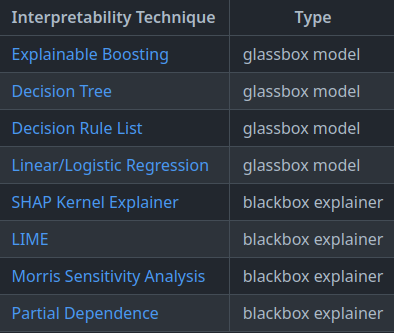

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

############## create EBM model #############
ebm = ExplainableBoostingClassifier()
ebm.fit(X, y)

############## visualizations #############

# Generate global explanability visuals
global_exp=ebm.explain_global()
show(global_exp)

In [ ]:

# Generate local explanability visuals
ebm_local = ebm.explain_local(X, y)
show(ebm_local)

# Lab time


1.   Using _interpret_ library, measure the classification performance of XGBoost vs the model of choice from _interpret_ on `shap.datasets.diabetes` (HINT: for metrics, you may use `sklearn.metrics`)
2.   Split the data into train-test set, conduct explanations only on test. Explain in a few sentences what went wrong when the classifier is mis-classifying.

